In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
#from statsmodels.formula.api import ols
#import statsmodels.formula.api as smf
from scipy import stats
import scipy.stats.distributions as dist

In [6]:
def filter_variables(df, dict_variables) :
    inicial = True
    for key in dict_variables.keys() :
        if type(dict_variables[key]) == str:
            if inicial :
                filtro = f"({key}\'{dict_variables[key]}\')"
                inicial = False
            else:
                filtro = filtro + f" and ({key}\'{dict_variables[key]}\')"
        else:
            if inicial :
                filtro = f"({key}{dict_variables[key]})"
                inicial = False
            else:
                filtro = filtro + f" and ({key}{dict_variables[key]})"

    return pd.DataFrame(df.query(filtro))

In [ ]:
data = pd.read_csv('performances.csv')
data.shape

In [61]:
df_training = filter_variables(data, {
    'stage==':'Training rounds'
})
df_training.head()

,treatment,stage,dyad,player,expert_in,novice_in,round,object,position,kind,classif,accuracy,expert_dog,queried,answer_correct,answered,yes/no
0,single,Training rounds,32519-32519,325192931513079,terrier,hound,1,C11.jpg,frame1,C,C,1,True,NaN,NaN,NaN,NaN
1,single,Training rounds,32519-32519,325192931513079,terrier,hound,1,A1.jpg,frame2,A,C,0,True,NaN,NaN,NaN,NaN
2,single,Training rounds,32519-32519,325192931513079,terrier,hound,1,A7.jpg,frame3,A,A,1,True,NaN,NaN,NaN,NaN
3,single,Training rounds,32519-32519,325192931513079,terrier,hound,1,A6.jpg,frame4,A,A,1,True,NaN,NaN,NaN,NaN
4,single,Training rounds,32519-32519,325192931513079,terrier,hound,1,A5.jpg,frame5,A,A,1,True,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='round', ylabel='accuracy'>

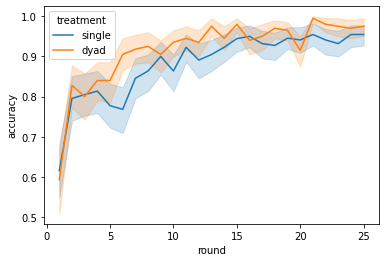

In [62]:
sns.lineplot(x='round', y='accuracy', 
             hue='treatment', data=df_training,
             estimator=lambda x:sum(x)/len(x),
             ci=95
            )

In [63]:
pd.crosstab(df_training['accuracy'], df_training['treatment'])

treatment,dyad,single
accuracy,,
0,385,633
1,4510,4822


In [65]:
pd.crosstab(df_training['accuracy'], df_training['treatment']).apply(lambda r:r/r.sum(),axis=0)

treatment,dyad,single
accuracy,,
0,0.078652,0.11604
1,0.921348,0.88396


In [58]:
pvalue = test_difference_proportions_accuracy(df_training, 'treatment') # Multiplied by two indicates a two tailed testing.
print("Computed p-value is", pvalue)
if pvalue < 0.05:
    print('Reject H0: proportions are not equal.')
else:
    print('Cannot reject H0: proportions are equal.')

Computed p-value is 1.8048749754428522e-10
Reject H0: proportions are not equal.


In [22]:
df_game = filter_variables(data, {
    'stage==':'Game rounds',
    'expert_dog==':False
})

<AxesSubplot:xlabel='round', ylabel='accuracy'>

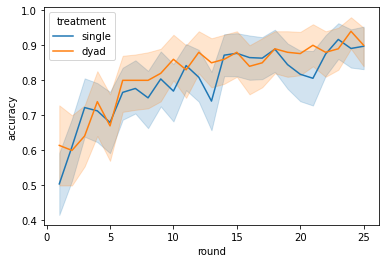

In [45]:
sns.lineplot(x='round', y='accuracy', 
             hue='treatment', data=df_game,
             estimator=lambda x:sum(x)/len(x),
             ci=95
            )

In [24]:
pd.crosstab(df_game['accuracy'], df_game['treatment'])

treatment,dyad,single
accuracy,,
0,429,561
1,2007,2199


In [25]:
pd.crosstab(df_game['accuracy'], df_game['treatment']).apply(lambda r:r/r.sum(),axis=0)

treatment,dyad,single
accuracy,,
0,0.176108,0.203261
1,0.823892,0.796739


In [26]:
total_proportion_accuracy = df_game['accuracy'].mean()
num_single = df_game[df_game['treatment']=="single"].shape[0]
num_dyad = df_game[df_game['treatment']=="dyad"].shape[0]
#This table helps us to calculate the SE.
prop = df_game.groupby("treatment")["accuracy"].agg([lambda z: np.mean(z==1), "size"])
prop.columns = ['proportions_accuracy','total_counts']
prop.head()

,proportions_accuracy,total_counts
treatment,,
dyad,0.823892,2436
single,0.796739,2760


In [27]:
#Calculating standard error
variance = total_proportion_accuracy * (1 - total_proportion_accuracy)
standard_error = np.sqrt(variance * (1 / prop.total_counts.single + 1 / prop.total_counts.dyad))
print("Sample Standard Error",standard_error)

Sample Standard Error 0.010917532093506408


In [28]:
# Calculate the test statistic 
best_estimate = (prop.proportions_accuracy.single - prop.proportions_accuracy.dyad)
print("The best estimate is",best_estimate)
hypothesized_estimate = 0
test_stat = (best_estimate-hypothesized_estimate) / standard_error
print("Computed Test Statistic is",test_stat)

The best estimate is -0.02715249518098095
Computed Test Statistic is -2.487054303887127


In [29]:
# Calculate the  p-value
pvalue = 2*dist.norm.cdf(-np.abs(test_stat)) # Multiplied by two indicates a two tailed testing.
print("Computed P-value is", pvalue)

Computed P-value is 0.012880573605038506


In [30]:
def test_difference_proportions_accuracy(df, variable:str):
    treatments = df[variable].unique().tolist()
    assert(len(treatments) == 2)
    treatment1 = treatments[0]
    treatment2 = treatments[1]
    total_proportion_accuracy = df['accuracy'].mean()
    prop = df.groupby(variable)["accuracy"].agg([lambda z: np.mean(z==1), "size"])
    prop.columns = ['proportions_accuracy','total_counts']
    variance = total_proportion_accuracy * (1 - total_proportion_accuracy)
    standard_error = np.sqrt(variance * (1 / prop.total_counts[treatment1] + 1 / prop.total_counts[treatment2]))
    best_estimate = (prop.proportions_accuracy[treatment1] - prop.proportions_accuracy[treatment2])
    hypothesized_estimate = 0
    test_stat = (best_estimate-hypothesized_estimate) / standard_error
    return 2*dist.norm.cdf(-np.abs(test_stat)) # Multiplied by two indicates a two tailed testing.


In [31]:
pvalue = test_difference_proportions_accuracy(df_game, 'treatment') # Multiplied by two indicates a two tailed testing.
print("Computed P-value is", pvalue)

Computed P-value is 0.012880573605038506


<AxesSubplot:xlabel='treatment', ylabel='accuracy'>

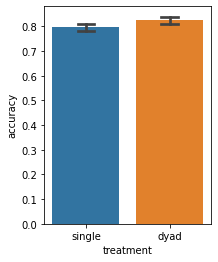

In [36]:
fig, ax = plt.subplots(figsize=(3,4))
sns.barplot(x='treatment', y='accuracy', data=df_game, capsize=.2)

In [14]:
for round, grp in df_game.groupby('round'):
    pvalue = test_difference_proportions_accuracy(grp, 'treatment')
    print(pvalue)

0.14682580235331444
0.8777514007871419
0.21951455295961364
0.6830999875414241
0.8837940680877097
0.5336312754127237
0.6841478500667864
0.39295633913365613
0.7700176816075541
0.09598135586117683
0.8112015264349062
0.152935024416633
0.0518796170706871
0.7990865281847505
0.9466399990814812
0.6104613709896018
0.7810189828317622
0.9796321991684958
0.45608019217534956
0.24730088750130985
0.058725570887376476
0.9117822204002637
0.5145263294504822
0.20438002175674042
0.9467688403081148


In [15]:
game_dyad = filter_variables(data, {
    'treatment==':'dyad', 
    'stage==':'Game rounds',
    'expert_dog==':False,
    'round<': 30
})
game_dyad['num_queries'] = game_dyad['queried'].apply(lambda x: x if x>0 else 0)
game_dyad['queried'] = game_dyad['queried'].apply(lambda x: 1 if x>0 else 0)
game_dyad.head()

,treatment,stage,dyad,player,expert_in,novice_in,round,object,position,kind,classif,accuracy,expert_dog,queried,answer_correct,answered,yes/no,num_queries
11206,dyad,Game rounds,45981-38174,459819203408978,hound,terrier,1,C1.jpg,frame2,C,A,0,False,0,NaN,NaN,NaN,0.0
11209,dyad,Game rounds,45981-38174,459819203408978,hound,terrier,1,A10.jpg,frame5,A,C,0,False,0,NaN,NaN,NaN,0.0
11210,dyad,Game rounds,45981-38174,38174543864515,terrier,hound,1,B1.jpg,frame1,B,B,1,False,0,NaN,NaN,NaN,0.0
11212,dyad,Game rounds,45981-38174,38174543864515,terrier,hound,1,B5.jpg,frame3,B,D,0,False,0,NaN,NaN,NaN,0.0
11213,dyad,Game rounds,45981-38174,38174543864515,terrier,hound,1,B8.jpg,frame4,B,D,0,False,0,NaN,NaN,NaN,0.0


In [16]:
df_use = game_dyad.groupby(['player', 'round']).agg({
    'num_queries':'sum',
    'queried':'mean',
}).reset_index()
df_use['acc_queried'] = df_use.groupby('player')['queried'].cumsum()
df_use.head()

,player,round,num_queries,queried,acc_queried
0,21409433577947,3,2.0,0.333333,0.333333
1,21409433577947,4,2.0,0.333333,0.666667
2,21409433577947,5,3.0,0.333333,1.000000
3,21409433577947,6,4.0,0.500000,1.500000
4,21409433577947,7,3.0,1.000000,2.500000


In [17]:
pvalue = test_difference_proportions_accuracy(game_dyad, 'queried')
print('p value:', pvalue)

p value: 1.449845554550943e-09


<AxesSubplot:xlabel='queried', ylabel='accuracy'>

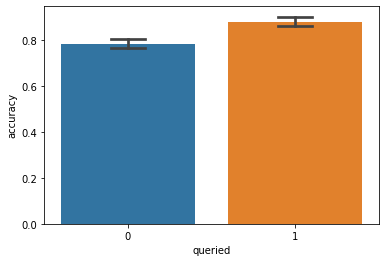

In [18]:
sns.barplot(x='queried', y='accuracy', data=game_dyad, capsize=.2)

In [188]:
df_use.groupby('player')['acc_queried'].max().describe()

count    40.000000
mean      9.701667
std       8.086496
min       0.000000
25%       2.125000
50%       7.450000
75%      16.783333
max      23.000000
Name: acc_queried, dtype: float64

In [189]:
df_use['use_grp'] = pd.cut(df_use['acc_queried'], 
                                   bins=[0, .5, 7.5, 16.8, 25], 
                                   include_lowest=True,
                                   labels=['very_low', 'low', 'mid', 'high'])
df_use.head()

,player,round,num_queries,queried,acc_queried,use_grp
0,21409433577947,3,2.0,0.333333,0.333333,very_low
1,21409433577947,4,2.0,0.333333,0.666667,low
2,21409433577947,5,3.0,0.333333,1.000000,low
3,21409433577947,6,4.0,0.500000,1.500000,low
4,21409433577947,7,3.0,1.000000,2.500000,low


In [190]:
df_use[df_use['use_grp'].isna()]

,player,round,num_queries,queried,acc_queried,use_grp


In [191]:
dict_use_grp = dict(zip(df_use['player'], df_use['use_grp']))
game_dyad['use_grp'] = game_dyad['player'].map(dict_use_grp)
df_extremes = pd.DataFrame(game_dyad[(game_dyad['use_grp']=='very_low') | (game_dyad['use_grp']=='high')])

<AxesSubplot:xlabel='round', ylabel='accuracy'>

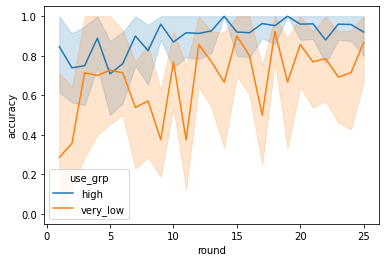

In [192]:
sns.lineplot(x='round', y='accuracy', 
             hue='use_grp', data=df_extremes,
             ci=95
            )

In [193]:
ps = []
for round, grp in df_extremes.groupby('round'):
    pvalue = test_difference_proportions_accuracy(grp, 'use_grp')
    ps.append(pvalue)
    print(pvalue)

0.012198069468642117
0.021721504010320757
0.8527765917754351
0.16626420916146145
0.9083329294347078
0.7538011572340367
0.017884152755544985
0.09071690093480289
3.7231566325456016e-05
0.4378134060070694
0.001329615698769901
0.5953645977817879
0.1604603907525366
0.002237857547804372
0.8485720888307413
0.28903354254194435
0.00050671939916592
0.7241594651964933
0.0017279507741690477
0.24753846024101755
0.0620343608710421
0.43371406902579557
0.02056151738544065
0.03180824149348401
0.58621368107314


Text(0.5, 0, 'round')

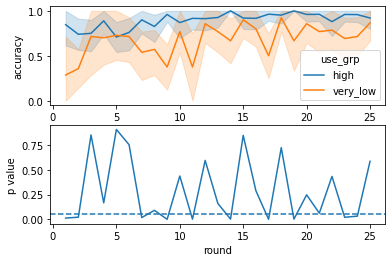

In [194]:
fig, ax = plt.subplots(2,1)
sns.lineplot(x='round', y='accuracy', 
             hue='use_grp', data=df_extremes,
             ci=95, ax=ax[0]
            )
sns.lineplot(x=range(1, 26), y=ps, ax=ax[1])
ax[1].axhline(.05, ls='--')
ax[1].set_ylabel('p value')
ax[1].set_xlabel('round')

In [195]:
df_high = pd.DataFrame(game_dyad[game_dyad['use_grp']=='high'])
df_no = filter_variables(data, {
    'stage==':'Game rounds',
    'expert_dog==':False,
    'treatment==':'single' 
})
df_no['use_grp'] = 'single'
df1 = pd.concat([df_high, df_no])

Text(0.5, 0, 'round')

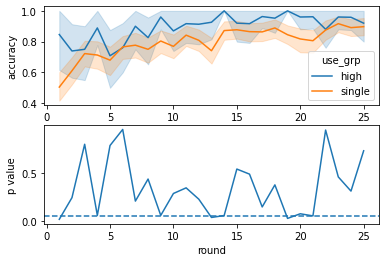

In [196]:
ps = []
for round, grp in df1.groupby('round'):
    pvalue = test_difference_proportions_accuracy(grp, 'use_grp')
    ps.append(pvalue)
    
fig, ax = plt.subplots(2,1)
sns.lineplot(x='round', y='accuracy', 
             hue='use_grp', data=df1,
             ci=95, ax=ax[0]
            )
sns.lineplot(x=range(1, 26), y=ps, ax=ax[1])
ax[1].axhline(.05, ls='--')
ax[1].set_ylabel('p value')
ax[1].set_xlabel('round')

In [7]:
report_understanding = pd.read_csv('rep-understanding.csv')
report_dyads = filter_variables(report_understanding, {
    'treatment==':'dyad', 
    'expertise==':'novices'}
                                 )
report_dyads['use_grp'] = report_dyads['player'].map(dict_use_grp)
report_dyads.head()

NameError: name 'dict_use_grp' is not defined

<AxesSubplot:xlabel='use_grp', ylabel='report'>

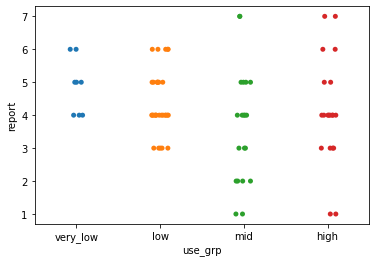

In [203]:
sns.stripplot(x='use_grp', y='report', data=report_dyads, 
              order=['very_low', 'low', 'mid', 'high'])